In [1]:
from bloqade import start
from qutip import basis, mesolve, Qobj, QobjEvo
import matplotlib.pyplot as plt
import numpy as np

from util import pretty, mk_H_Rydberg, histogram_final_state, plot_histogram, invert_keys

# Adiabatic Quantum Computing with Neutral Atoms 

In this notebook, we will introduce adiabatic quantum computing (AQC) with neutral atoms.

## Review: Adiabatic Quantum Computing

Recall that an **adiabatic quantum program** is a tuple

$$
(H_t, T)
$$ 

where $H_t$ is a time-dependent Hamiltonian defined for $t \in [0, T]$ and such that $H_t$ has a unique ground state $\ket{\psi(t)}$ for all $0 \leq t \leq T$ where $T$ is the length of simulation. 

An adiabatic evolution then performs the computation

$$
\text{GroundState}(H_0) \rightarrow_T \text{GroundState}(H_T)
$$

in time $T$.

## Example: $\ket{0} \rightarrow \ket{1}$

We will now set up a computation that flips a qubit from $\ket{0}$ to $\ket{1}$. As a reminder, the **Rydberg Hamiltonian** on a single qubit (i.e., Rydberg atom) is given as

$$
\frac{1}{\hbar} H_{\text{Rydberg}}(t) = \begin{pmatrix}
0 & \frac{\Omega(t)}{2} e^{i\phi(t)} \\
\frac{\Omega(t)}{2} e^{-i\phi(t)} & -\Delta(t)
\end{pmatrix} 
$$

where 
1. $\Omega(t)$ is a **Rabi frequency**,
2. $\phi(t)$ is the **Rabi phase**, and
3. $\Delta(t)$ is the **detuning** of the driving laser.

### Initial Hamiltonian

We need to construct a Rydberg Hamiltonian whose ground state is $\ket{0}$. One such Hamiltonian is given below where we set the detuning to a negative number.

In [2]:
Omega_init = 0
phi = 0
Delta_init = -30
register = start.add_position([(0, 0)])  # (um)
H_init = mk_H_Rydberg(1, Omega_init, phi, Delta_init, register)
pretty(H_init)

<IPython.core.display.Latex object>

In [3]:
eigvals, eigs = np.linalg.eigh(H_init)
idxs = np.argsort(eigvals)
assert eigvals[idxs[0]] < np.max(eigvals[idxs[1:]])
print(eigvals[idxs])
pretty(eigs[:, idxs[0]])

[ 0. 30.]


<IPython.core.display.Latex object>

### Final Hamiltonian

Next, we construct a Rydberg Hamiltonian whose ground state is $\ket{1}$. One such Hamiltonian is given below where we set the detuning to a positive number.

In [4]:
Omega_final = 0
Delta_final = 30
H_final = mk_H_Rydberg(1, Omega_final, phi, Delta_final, register)
pretty(H_final)

<IPython.core.display.Latex object>

In [5]:
eigvals, eigs = np.linalg.eigh(H_final)
idxs = np.argsort(eigvals)
assert eigvals[idxs[0]] < np.max(eigvals[idxs[1:]])
print(eigvals[idxs])
pretty(eigs[:, idxs[0]])

[-30.   0.]


<IPython.core.display.Latex object>

### Bloqade Program

We can now construct a Bloqade program to perform this adiabatic computation. One issues is that we require a non-zero $\Omega$ at some point during the computation. Otherwise, our qubits will not oscillate between $\ket{0}$ and $\ket{1}$. To accomplish this we can ramp up $\Omega$ from $0$ to $15$ and back down to $0$ to match our intial and final Hamiltonian above. If we perform these transitions slowly enough, the adiabatic theorem will apply and we will successfully perform our computation.

In [6]:
T = np.pi*4
register = start.add_position([(0, 0)])  # (um)
program = (
    register
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=[0.2, T - 0.4, 0.2],
        values=[0, 15, 15, 0]
    )
    .rydberg.rabi.phase.uniform.piecewise_constant(
        durations=[T],
        values=[0]
    )
    .rydberg.detuning.uniform.piecewise_linear(
        durations=[T],
        values=[-30, 30]
    )
)

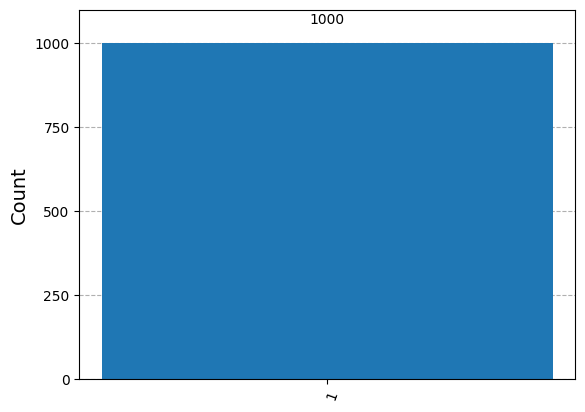

In [7]:
results = program.bloqade.python().run(1000)
report = results.report()
plot_histogram(invert_keys(report.counts()))

### QuTip Solving

We can also manually implement this Rydberg Hamiltonian using the more generic `qutip` library as a sanity check.

Text(0.5, 0, 'Time t')

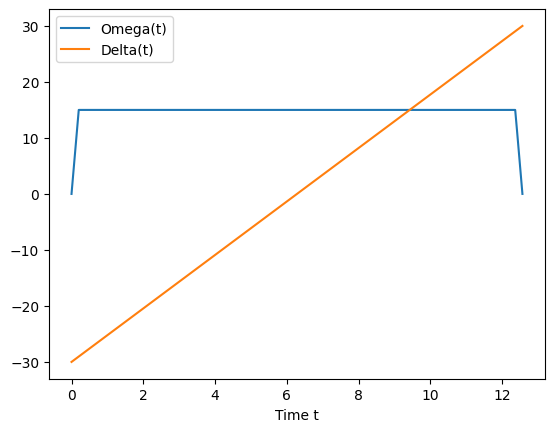

In [8]:
T = np.pi*4
phi = 0
times = np.linspace(0, T, 500)

def Omega(t):
    if t < 0.2:
        return 15/.2*t
    elif t < T - 0.2:
        return 15
    else:
        t = T - t
        return 15/.2*t

def Delta(t):
    return Delta_init + (Delta_final - Delta_init)/T*t

plt.plot(times, [Omega(t) for t in times], label="Omega(t)")
plt.plot(times, [Delta(t) for t in times], label="Delta(t)")
plt.legend()
plt.xlabel("Time t")

In [9]:
# Construct the time-dependent Hamiltonian
H_list = [Qobj(mk_H_Rydberg(1, Omega(t), phi, Delta(t), register), dims=[[2], [2]]) for t in times]
H = QobjEvo(H_list, tlist=times)
result = mesolve(H, basis(2, 0), times, [], [])
pretty(result.final_state)

<IPython.core.display.Latex object>

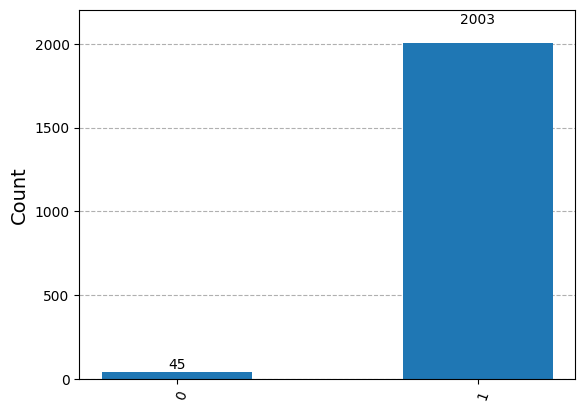

In [10]:
plot_histogram(histogram_final_state(result.final_state))

## Summary

We saw a simple example of performing an adiabatic computation with neutral atoms.

## References

[1] [Rydberg Hamiltonian](https://queracomputing.github.io/Bloqade.jl/dev/hamiltonians/#Hamiltonians)

[2] [Adiabatic Evolution](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/)